# US Market Daily Liquidity Analysis

This notebook analyzes daily liquidity conditions in US equity markets using multiple indicators:
- **Volume-based metrics**: Trading volume, dollar volume, volume ratios
- **Volatility proxies**: VIX, realized volatility
- **Market breadth**: Advance-decline, new highs/lows
- **Spread indicators**: High-low range as liquidity proxy
- **Regime detection**: Identifying high/low liquidity environments

In [1]:
# Core imports
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Plot styling
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 11

print("Libraries loaded successfully")

Libraries loaded successfully


## 1. Data Fetching

Fetch key market data for liquidity analysis:
- SPY (S&P 500 ETF) - primary liquidity benchmark
- QQQ (Nasdaq 100 ETF) - tech sector liquidity
- IWM (Russell 2000 ETF) - small cap liquidity
- VIX - volatility/fear index
- TLT (20+ Year Treasury ETF) - flight to safety indicator

In [2]:
# Define date range (2 years of data)
end_date = datetime.today()
start_date = end_date - timedelta(days=730)

# Tickers for liquidity analysis
tickers = ['SPY', 'QQQ', 'IWM', '^VIX', 'TLT', 'HYG']

print(f"Fetching data from {start_date.strftime('%Y-%m-%d')} to {end_date.strftime('%Y-%m-%d')}")

# Fetch data
data = {}
for ticker in tickers:
    print(f"Downloading {ticker}...")
    data[ticker] = yf.download(ticker, start=start_date, end=end_date, progress=False)
    
print(f"\nData fetched successfully. SPY has {len(data['SPY'])} trading days.")

Fetching data from 2024-01-22 to 2026-01-21



Data fetched successfully. SPY has 502 trading days.


In [3]:
# Create main dataframe with key liquidity metrics
liquidity_df = pd.DataFrame(index=data['SPY'].index)

# Price data
liquidity_df['SPY_Close'] = data['SPY']['Close']
liquidity_df['SPY_Volume'] = data['SPY']['Volume']
liquidity_df['QQQ_Volume'] = data['QQQ']['Volume']
liquidity_df['IWM_Volume'] = data['IWM']['Volume']

# VIX
liquidity_df['VIX'] = data['^VIX']['Close']

# High-Low range (intraday volatility proxy)
liquidity_df['SPY_Range'] = (data['SPY']['High'] - data['SPY']['Low']) / data['SPY']['Close'] * 100

# Dollar volume (volume * price)
liquidity_df['SPY_Dollar_Volume'] = data['SPY']['Volume'] * data['SPY']['Close']

# Returns
liquidity_df['SPY_Return'] = data['SPY']['Close'].pct_change() * 100

liquidity_df.dropna(inplace=True)
print(f"Liquidity dataframe created with {len(liquidity_df)} rows")
liquidity_df.head()

Liquidity dataframe created with 500 rows


,SPY_Close,SPY_Volume,QQQ_Volume,IWM_Volume,VIX,SPY_Range,SPY_Dollar_Volume,SPY_Return
Date,,,,,,,,
2024-01-23,473.162872,49945300,33003800.0,42471200.0,12.55,0.457858,2.363226e+10,0.291646
2024-01-24,473.680115,81765000,46948000.0,41120100.0,13.14,0.801414,3.873045e+10,0.109316
2024-01-25,476.256470,72525000,44367200.0,37659500.0,13.45,0.598320,3.454050e+10,0.543902
2024-01-26,475.651398,76641600,37137000.0,33478600.0,13.26,0.529326,3.645468e+10,-0.127048
2024-01-29,479.418213,61322800,38694700.0,29234400.0,13.60,0.865105,2.939927e+10,0.791928


## 2. Volume-Based Liquidity Analysis

Volume is the most direct measure of market liquidity. Higher volume generally indicates:
- Better price discovery
- Tighter bid-ask spreads
- Lower market impact for large orders

In [4]:
# Calculate volume metrics
liquidity_df['SPY_Volume_MA20'] = liquidity_df['SPY_Volume'].rolling(20).mean()
liquidity_df['SPY_Volume_MA50'] = liquidity_df['SPY_Volume'].rolling(50).mean()
liquidity_df['Volume_Ratio'] = liquidity_df['SPY_Volume'] / liquidity_df['SPY_Volume_MA20']

# Dollar volume moving averages
liquidity_df['Dollar_Volume_MA20'] = liquidity_df['SPY_Dollar_Volume'].rolling(20).mean()

# Volume z-score (standardized volume)
vol_mean = liquidity_df['SPY_Volume'].rolling(50).mean()
vol_std = liquidity_df['SPY_Volume'].rolling(50).std()
liquidity_df['Volume_ZScore'] = (liquidity_df['SPY_Volume'] - vol_mean) / vol_std

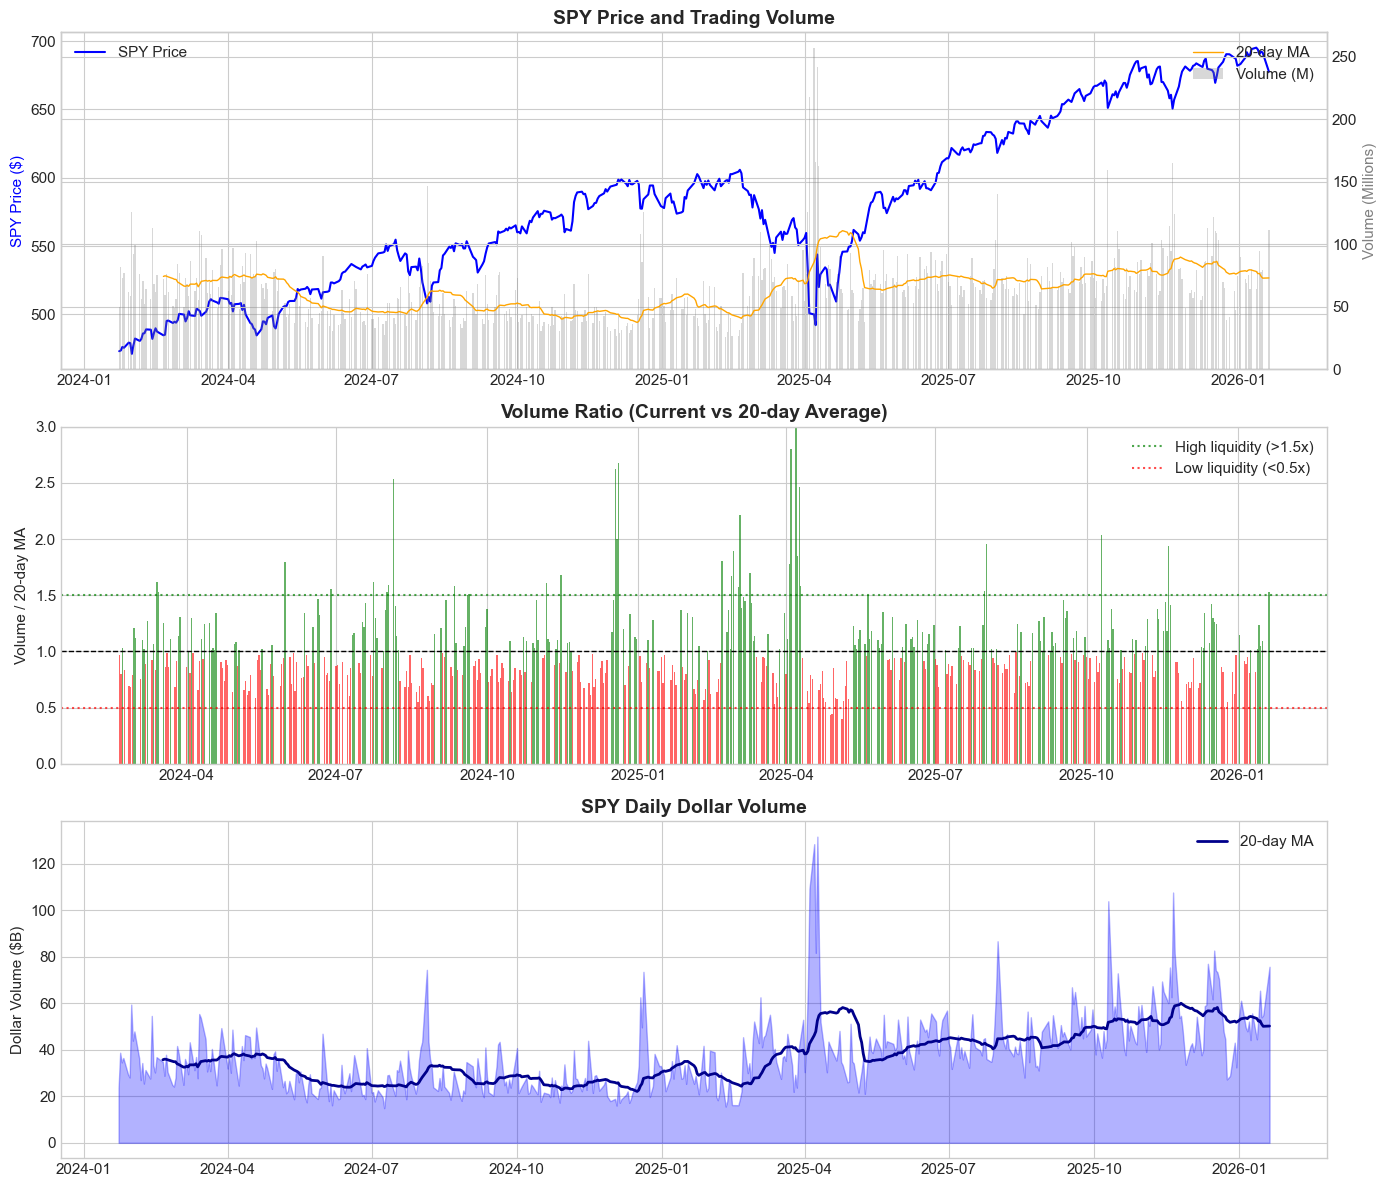

In [5]:
# Plot volume analysis
fig, axes = plt.subplots(3, 1, figsize=(14, 12))

# Plot 1: SPY Price with Volume
ax1 = axes[0]
ax1.plot(liquidity_df.index, liquidity_df['SPY_Close'], color='blue', linewidth=1.5, label='SPY Price')
ax1.set_ylabel('SPY Price ($)', color='blue')
ax1.set_title('SPY Price and Trading Volume', fontsize=14, fontweight='bold')
ax1.legend(loc='upper left')

ax1b = ax1.twinx()
ax1b.bar(liquidity_df.index, liquidity_df['SPY_Volume']/1e6, alpha=0.3, color='gray', label='Volume (M)')
ax1b.plot(liquidity_df.index, liquidity_df['SPY_Volume_MA20']/1e6, color='orange', linewidth=1, label='20-day MA')
ax1b.set_ylabel('Volume (Millions)', color='gray')
ax1b.legend(loc='upper right')

# Plot 2: Volume Ratio
ax2 = axes[1]
colors = ['green' if x > 1 else 'red' for x in liquidity_df['Volume_Ratio']]
ax2.bar(liquidity_df.index, liquidity_df['Volume_Ratio'], color=colors, alpha=0.6)
ax2.axhline(y=1, color='black', linestyle='--', linewidth=1)
ax2.axhline(y=1.5, color='green', linestyle=':', alpha=0.7, label='High liquidity (>1.5x)')
ax2.axhline(y=0.5, color='red', linestyle=':', alpha=0.7, label='Low liquidity (<0.5x)')
ax2.set_ylabel('Volume / 20-day MA')
ax2.set_title('Volume Ratio (Current vs 20-day Average)', fontsize=14, fontweight='bold')
ax2.set_ylim(0, 3)
ax2.legend()

# Plot 3: Dollar Volume Trend
ax3 = axes[2]
ax3.fill_between(liquidity_df.index, liquidity_df['SPY_Dollar_Volume']/1e9, alpha=0.3, color='blue')
ax3.plot(liquidity_df.index, liquidity_df['Dollar_Volume_MA20']/1e9, color='darkblue', linewidth=2, label='20-day MA')
ax3.set_ylabel('Dollar Volume ($B)')
ax3.set_title('SPY Daily Dollar Volume', fontsize=14, fontweight='bold')
ax3.legend()

plt.tight_layout()
plt.show()

In [6]:
# Volume statistics
print("=" * 60)
print("SPY VOLUME STATISTICS")
print("=" * 60)
print(f"\nAverage Daily Volume: {liquidity_df['SPY_Volume'].mean()/1e6:.1f}M shares")
print(f"Average Dollar Volume: ${liquidity_df['SPY_Dollar_Volume'].mean()/1e9:.2f}B")
print(f"\nCurrent Volume Ratio: {liquidity_df['Volume_Ratio'].iloc[-1]:.2f}x")
print(f"Current Volume Z-Score: {liquidity_df['Volume_ZScore'].iloc[-1]:.2f}")
print(f"\nDays with Above-Average Volume: {(liquidity_df['Volume_Ratio'] > 1).sum()} ({(liquidity_df['Volume_Ratio'] > 1).mean()*100:.1f}%)")
print(f"Days with High Volume (>1.5x): {(liquidity_df['Volume_Ratio'] > 1.5).sum()} ({(liquidity_df['Volume_Ratio'] > 1.5).mean()*100:.1f}%)")
print(f"Days with Low Volume (<0.5x): {(liquidity_df['Volume_Ratio'] < 0.5).sum()} ({(liquidity_df['Volume_Ratio'] < 0.5).mean()*100:.1f}%)")

SPY VOLUME STATISTICS

Average Daily Volume: 64.7M shares
Average Dollar Volume: $37.63B

Current Volume Ratio: 1.53x
Current Volume Z-Score: 1.25

Days with Above-Average Volume: 201 (40.2%)
Days with High Volume (>1.5x): 34 (6.8%)
Days with Low Volume (<0.5x): 3 (0.6%)


## 3. VIX and Volatility-Based Liquidity

The VIX (fear index) is inversely correlated with liquidity:
- High VIX = Market stress, wider spreads, lower liquidity
- Low VIX = Calm markets, tighter spreads, better liquidity

In [7]:
# VIX-based liquidity metrics
liquidity_df['VIX_MA20'] = liquidity_df['VIX'].rolling(20).mean()
liquidity_df['VIX_Percentile'] = liquidity_df['VIX'].rolling(252).apply(lambda x: pd.Series(x).rank(pct=True).iloc[-1])

# Realized volatility (20-day)
liquidity_df['Realized_Vol'] = liquidity_df['SPY_Return'].rolling(20).std() * np.sqrt(252)

# VIX-RV spread (implied vs realized)
liquidity_df['VIX_RV_Spread'] = liquidity_df['VIX'] - liquidity_df['Realized_Vol']

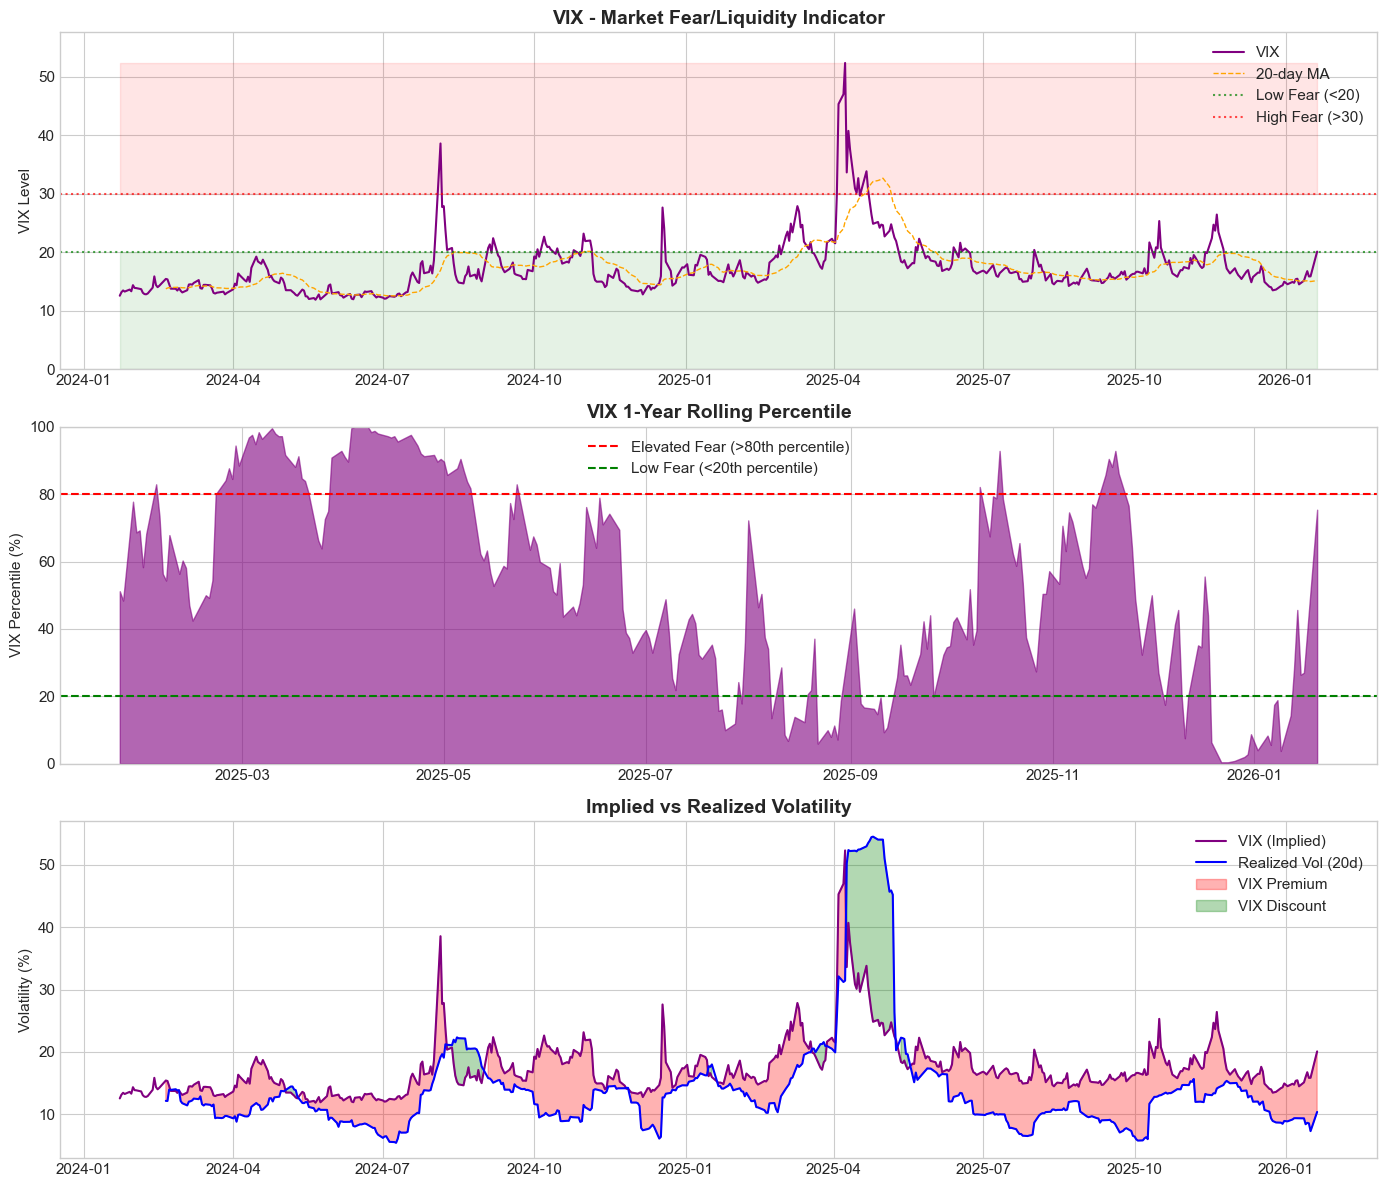

In [8]:
# Plot VIX analysis
fig, axes = plt.subplots(3, 1, figsize=(14, 12))

# Plot 1: VIX with levels
ax1 = axes[0]
ax1.plot(liquidity_df.index, liquidity_df['VIX'], color='purple', linewidth=1.5, label='VIX')
ax1.plot(liquidity_df.index, liquidity_df['VIX_MA20'], color='orange', linewidth=1, linestyle='--', label='20-day MA')
ax1.axhline(y=20, color='green', linestyle=':', alpha=0.7, label='Low Fear (<20)')
ax1.axhline(y=30, color='red', linestyle=':', alpha=0.7, label='High Fear (>30)')
ax1.fill_between(liquidity_df.index, 0, 20, alpha=0.1, color='green')
ax1.fill_between(liquidity_df.index, 30, liquidity_df['VIX'].max(), alpha=0.1, color='red')
ax1.set_ylabel('VIX Level')
ax1.set_title('VIX - Market Fear/Liquidity Indicator', fontsize=14, fontweight='bold')
ax1.legend(loc='upper right')
ax1.set_ylim(0, max(50, liquidity_df['VIX'].max() * 1.1))

# Plot 2: VIX Percentile
ax2 = axes[1]
ax2.fill_between(liquidity_df.index, liquidity_df['VIX_Percentile']*100, alpha=0.6, color='purple')
ax2.axhline(y=80, color='red', linestyle='--', label='Elevated Fear (>80th percentile)')
ax2.axhline(y=20, color='green', linestyle='--', label='Low Fear (<20th percentile)')
ax2.set_ylabel('VIX Percentile (%)')
ax2.set_title('VIX 1-Year Rolling Percentile', fontsize=14, fontweight='bold')
ax2.legend()
ax2.set_ylim(0, 100)

# Plot 3: VIX vs Realized Vol
ax3 = axes[2]
ax3.plot(liquidity_df.index, liquidity_df['VIX'], color='purple', linewidth=1.5, label='VIX (Implied)')
ax3.plot(liquidity_df.index, liquidity_df['Realized_Vol'], color='blue', linewidth=1.5, label='Realized Vol (20d)')
ax3.fill_between(liquidity_df.index, liquidity_df['VIX'], liquidity_df['Realized_Vol'], 
                  where=liquidity_df['VIX'] > liquidity_df['Realized_Vol'], alpha=0.3, color='red', label='VIX Premium')
ax3.fill_between(liquidity_df.index, liquidity_df['VIX'], liquidity_df['Realized_Vol'], 
                  where=liquidity_df['VIX'] <= liquidity_df['Realized_Vol'], alpha=0.3, color='green', label='VIX Discount')
ax3.set_ylabel('Volatility (%)')
ax3.set_title('Implied vs Realized Volatility', fontsize=14, fontweight='bold')
ax3.legend()

plt.tight_layout()
plt.show()

In [9]:
# VIX statistics
print("=" * 60)
print("VIX LIQUIDITY ANALYSIS")
print("=" * 60)
print(f"\nCurrent VIX: {liquidity_df['VIX'].iloc[-1]:.2f}")
print(f"20-day Average: {liquidity_df['VIX_MA20'].iloc[-1]:.2f}")
print(f"1-Year Percentile: {liquidity_df['VIX_Percentile'].iloc[-1]*100:.1f}%")
print(f"\nVIX-RV Spread: {liquidity_df['VIX_RV_Spread'].iloc[-1]:.2f}")
print(f"  (Positive = Fear premium, markets pricing in more risk)")

# Liquidity regime based on VIX
current_vix = liquidity_df['VIX'].iloc[-1]
if current_vix < 15:
    regime = "VERY HIGH LIQUIDITY (VIX < 15)"
elif current_vix < 20:
    regime = "HIGH LIQUIDITY (VIX 15-20)"
elif current_vix < 25:
    regime = "NORMAL LIQUIDITY (VIX 20-25)"
elif current_vix < 30:
    regime = "REDUCED LIQUIDITY (VIX 25-30)"
else:
    regime = "LOW LIQUIDITY / STRESS (VIX > 30)"
    
print(f"\nCurrent Liquidity Regime: {regime}")

VIX LIQUIDITY ANALYSIS

Current VIX: 20.09
20-day Average: 15.13
1-Year Percentile: 75.4%

VIX-RV Spread: 9.71
  (Positive = Fear premium, markets pricing in more risk)

Current Liquidity Regime: NORMAL LIQUIDITY (VIX 20-25)


## 4. Composite Liquidity Index

Combining multiple factors into a single liquidity score:
- Volume ratio (higher = more liquid)
- VIX level (lower = more liquid)
- Intraday range (lower = more liquid)

In [10]:
# Normalize components to 0-100 scale
def normalize_to_percentile(series, window=252):
    return series.rolling(window).apply(lambda x: pd.Series(x).rank(pct=True).iloc[-1]) * 100

# Volume component (higher is better)
liquidity_df['Volume_Score'] = normalize_to_percentile(liquidity_df['SPY_Volume'])

# VIX component (lower is better, so invert)
liquidity_df['VIX_Score'] = 100 - normalize_to_percentile(liquidity_df['VIX'])

# Range component (lower is better, so invert)
liquidity_df['Range_Score'] = 100 - normalize_to_percentile(liquidity_df['SPY_Range'])

# Composite Liquidity Index (equal weighted)
liquidity_df['Liquidity_Index'] = (
    liquidity_df['Volume_Score'] * 0.4 +
    liquidity_df['VIX_Score'] * 0.4 +
    liquidity_df['Range_Score'] * 0.2
)

# Smooth the index
liquidity_df['Liquidity_Index_MA5'] = liquidity_df['Liquidity_Index'].rolling(5).mean()

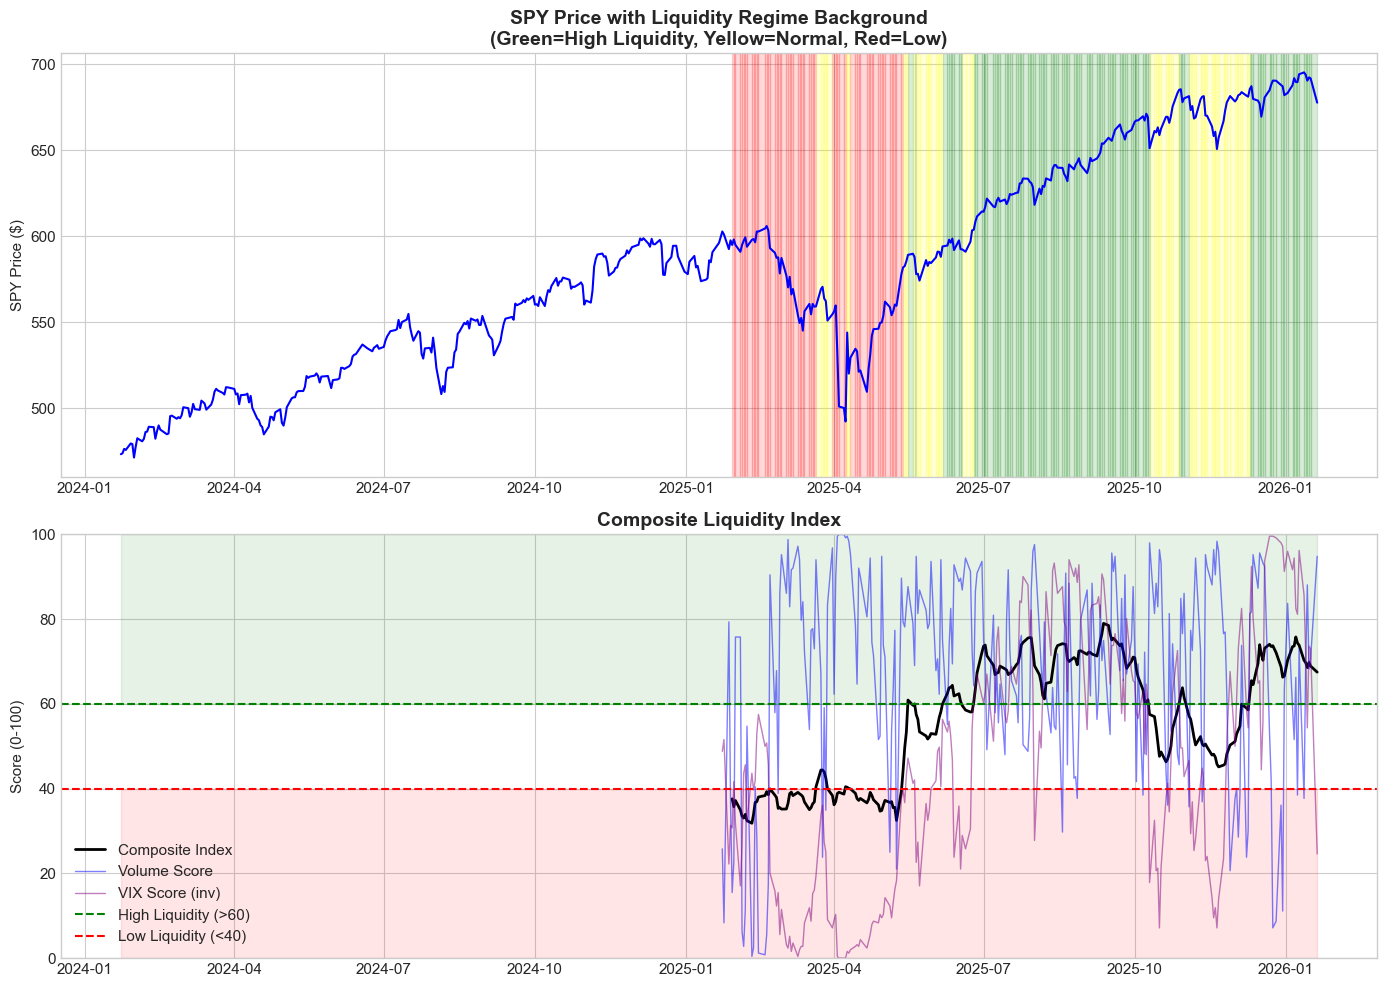

In [11]:
# Plot composite liquidity index
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Plot 1: SPY with Liquidity Index background
ax1 = axes[0]
ax1.plot(liquidity_df.index, liquidity_df['SPY_Close'], color='blue', linewidth=1.5)

# Color background based on liquidity
for i in range(len(liquidity_df)-1):
    liq = liquidity_df['Liquidity_Index_MA5'].iloc[i]
    if pd.notna(liq):
        if liq >= 60:
            color = 'green'
        elif liq >= 40:
            color = 'yellow'
        else:
            color = 'red'
        ax1.axvspan(liquidity_df.index[i], liquidity_df.index[i+1], alpha=0.15, color=color)

ax1.set_ylabel('SPY Price ($)')
ax1.set_title('SPY Price with Liquidity Regime Background\n(Green=High Liquidity, Yellow=Normal, Red=Low)', 
              fontsize=14, fontweight='bold')

# Plot 2: Liquidity Index components
ax2 = axes[1]
ax2.plot(liquidity_df.index, liquidity_df['Liquidity_Index_MA5'], color='black', linewidth=2, label='Composite Index')
ax2.plot(liquidity_df.index, liquidity_df['Volume_Score'], color='blue', alpha=0.5, linewidth=1, label='Volume Score')
ax2.plot(liquidity_df.index, liquidity_df['VIX_Score'], color='purple', alpha=0.5, linewidth=1, label='VIX Score (inv)')
ax2.axhline(y=60, color='green', linestyle='--', label='High Liquidity (>60)')
ax2.axhline(y=40, color='red', linestyle='--', label='Low Liquidity (<40)')
ax2.fill_between(liquidity_df.index, 60, 100, alpha=0.1, color='green')
ax2.fill_between(liquidity_df.index, 0, 40, alpha=0.1, color='red')
ax2.set_ylabel('Score (0-100)')
ax2.set_title('Composite Liquidity Index', fontsize=14, fontweight='bold')
ax2.legend(loc='lower left')
ax2.set_ylim(0, 100)

plt.tight_layout()
plt.show()

In [12]:
# Current liquidity summary
print("=" * 60)
print("COMPOSITE LIQUIDITY INDEX SUMMARY")
print("=" * 60)

latest = liquidity_df.iloc[-1]
print(f"\nDate: {liquidity_df.index[-1].strftime('%Y-%m-%d')}")
print(f"\nComponent Scores (0-100, higher = more liquid):")
print(f"  Volume Score: {latest['Volume_Score']:.1f}")
print(f"  VIX Score:    {latest['VIX_Score']:.1f}")
print(f"  Range Score:  {latest['Range_Score']:.1f}")
print(f"\n  COMPOSITE INDEX: {latest['Liquidity_Index_MA5']:.1f}")

# Interpretation
idx = latest['Liquidity_Index_MA5']
if idx >= 70:
    interpretation = "EXCELLENT - Very favorable conditions for trading"
elif idx >= 60:
    interpretation = "GOOD - Above average liquidity"
elif idx >= 50:
    interpretation = "NORMAL - Average market conditions"
elif idx >= 40:
    interpretation = "BELOW AVERAGE - Exercise caution with large orders"
else:
    interpretation = "POOR - Low liquidity, wider spreads expected"
    
print(f"\nInterpretation: {interpretation}")

COMPOSITE LIQUIDITY INDEX SUMMARY

Date: 2026-01-20

Component Scores (0-100, higher = more liquid):
  Volume Score: 94.8
  VIX Score:    24.6
  Range Score:  30.6

  COMPOSITE INDEX: 67.5

Interpretation: GOOD - Above average liquidity


## 5. Liquidity and Returns Analysis

Examining the relationship between liquidity conditions and subsequent market returns.

In [13]:
# Forward returns by liquidity regime
liquidity_df['Fwd_Return_1d'] = liquidity_df['SPY_Return'].shift(-1)
liquidity_df['Fwd_Return_5d'] = liquidity_df['SPY_Close'].pct_change(5).shift(-5) * 100
liquidity_df['Fwd_Return_20d'] = liquidity_df['SPY_Close'].pct_change(20).shift(-20) * 100

# Define liquidity regimes
def liquidity_regime(idx):
    if idx >= 60:
        return 'High'
    elif idx >= 40:
        return 'Normal'
    else:
        return 'Low'

liquidity_df['Regime'] = liquidity_df['Liquidity_Index_MA5'].apply(liquidity_regime)

In [14]:
# Returns by regime
regime_stats = liquidity_df.groupby('Regime').agg({
    'Fwd_Return_1d': ['mean', 'std', 'count'],
    'Fwd_Return_5d': ['mean', 'std'],
    'Fwd_Return_20d': ['mean', 'std']
}).round(3)

print("=" * 70)
print("FORWARD RETURNS BY LIQUIDITY REGIME")
print("=" * 70)
print("\n1-Day Forward Returns:")
for regime in ['High', 'Normal', 'Low']:
    if regime in regime_stats.index:
        mean_ret = regime_stats.loc[regime, ('Fwd_Return_1d', 'mean')]
        std_ret = regime_stats.loc[regime, ('Fwd_Return_1d', 'std')]
        count = regime_stats.loc[regime, ('Fwd_Return_1d', 'count')]
        print(f"  {regime:8s}: Mean={mean_ret:+.3f}%, Std={std_ret:.3f}%, Days={count:.0f}")

print("\n5-Day Forward Returns:")
for regime in ['High', 'Normal', 'Low']:
    if regime in regime_stats.index:
        mean_ret = regime_stats.loc[regime, ('Fwd_Return_5d', 'mean')]
        std_ret = regime_stats.loc[regime, ('Fwd_Return_5d', 'std')]
        print(f"  {regime:8s}: Mean={mean_ret:+.3f}%, Std={std_ret:.3f}%")

print("\n20-Day Forward Returns:")
for regime in ['High', 'Normal', 'Low']:
    if regime in regime_stats.index:
        mean_ret = regime_stats.loc[regime, ('Fwd_Return_20d', 'mean')]
        std_ret = regime_stats.loc[regime, ('Fwd_Return_20d', 'std')]
        print(f"  {regime:8s}: Mean={mean_ret:+.3f}%, Std={std_ret:.3f}%")

FORWARD RETURNS BY LIQUIDITY REGIME

1-Day Forward Returns:
  High    : Mean=+0.037%, Std=0.649%, Days=115
  Normal  : Mean=+0.281%, Std=1.626%, Days=66
  Low     : Mean=+0.050%, Std=0.988%, Days=318

5-Day Forward Returns:
  High    : Mean=+0.323%, Std=1.215%
  Normal  : Mean=+0.454%, Std=2.422%
  Low     : Mean=+0.410%, Std=2.219%

20-Day Forward Returns:
  High    : Mean=+2.178%, Std=1.417%
  Normal  : Mean=+1.654%, Std=3.419%
  Low     : Mean=+1.359%, Std=4.014%


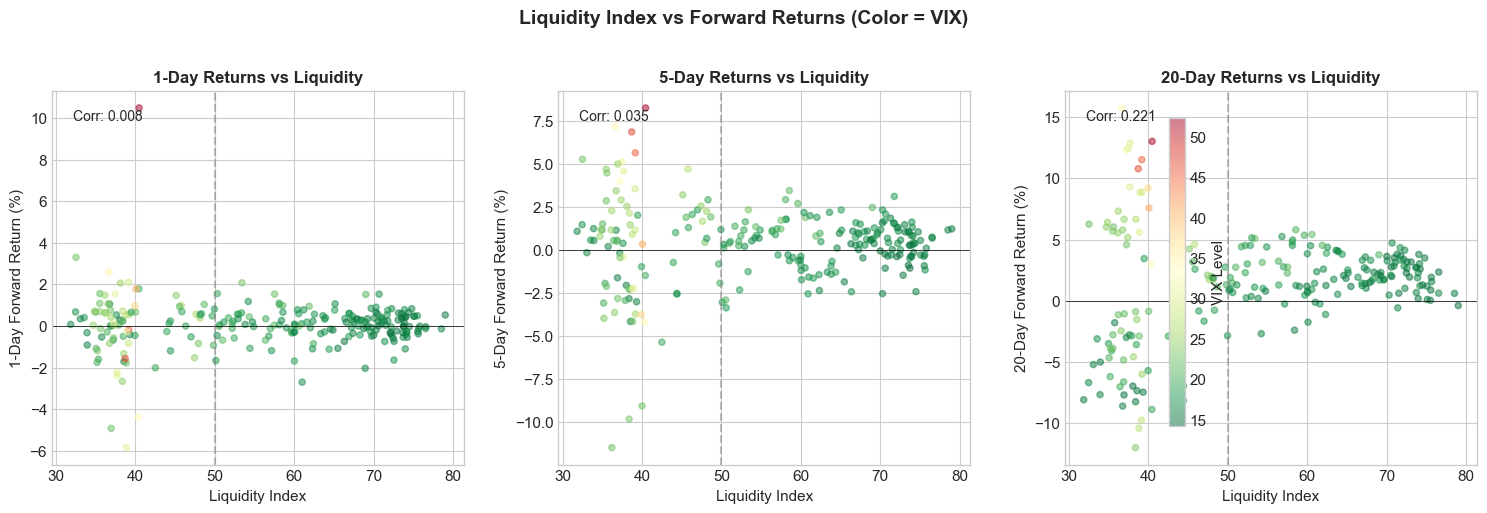

In [15]:
# Scatter plot: Liquidity vs Returns
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, (period, col) in enumerate([('1-Day', 'Fwd_Return_1d'), ('5-Day', 'Fwd_Return_5d'), ('20-Day', 'Fwd_Return_20d')]):
    ax = axes[i]
    
    # Color by VIX level
    scatter = ax.scatter(liquidity_df['Liquidity_Index_MA5'], liquidity_df[col], 
                         c=liquidity_df['VIX'], cmap='RdYlGn_r', alpha=0.5, s=20)
    
    ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    ax.axvline(x=50, color='gray', linestyle='--', alpha=0.5)
    ax.set_xlabel('Liquidity Index')
    ax.set_ylabel(f'{period} Forward Return (%)')
    ax.set_title(f'{period} Returns vs Liquidity', fontsize=12, fontweight='bold')
    
    # Add correlation
    valid_mask = liquidity_df[[col, 'Liquidity_Index_MA5']].notna().all(axis=1)
    corr = liquidity_df.loc[valid_mask, col].corr(liquidity_df.loc[valid_mask, 'Liquidity_Index_MA5'])
    ax.text(0.05, 0.95, f'Corr: {corr:.3f}', transform=ax.transAxes, fontsize=10, verticalalignment='top')

plt.colorbar(scatter, ax=axes, label='VIX Level', shrink=0.8)
plt.suptitle('Liquidity Index vs Forward Returns (Color = VIX)', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

## 6. Cross-Asset Liquidity Comparison

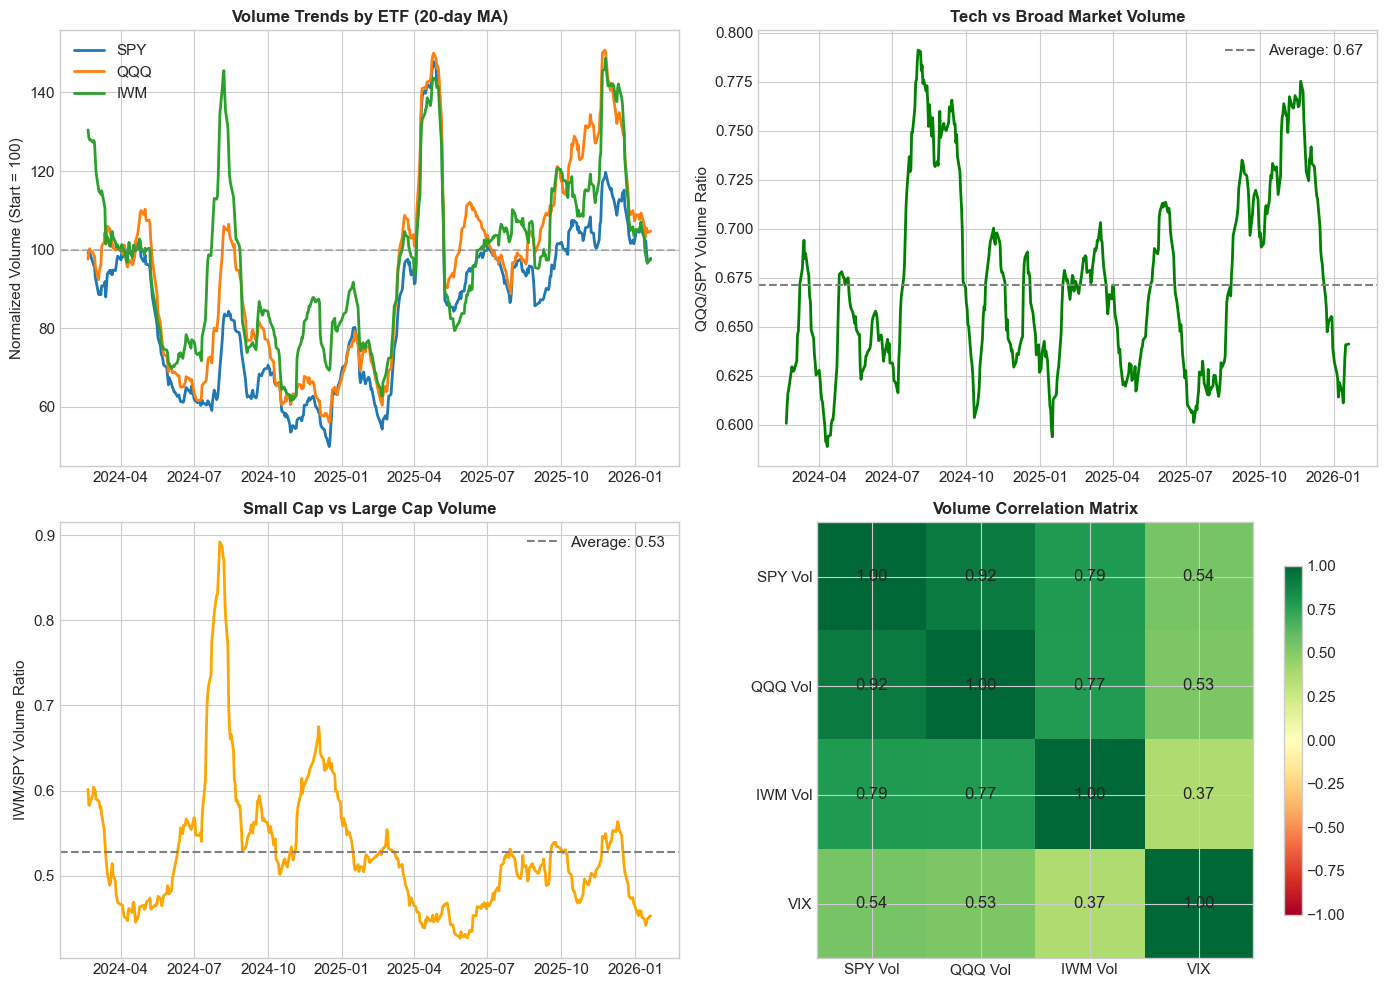

In [16]:
# Compare volume trends across ETFs
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Normalize volumes to starting point = 100
spy_vol_norm = liquidity_df['SPY_Volume'].rolling(20).mean() / liquidity_df['SPY_Volume'].rolling(20).mean().iloc[50] * 100
qqq_vol_norm = liquidity_df['QQQ_Volume'].rolling(20).mean() / liquidity_df['QQQ_Volume'].rolling(20).mean().iloc[50] * 100
iwm_vol_norm = liquidity_df['IWM_Volume'].rolling(20).mean() / liquidity_df['IWM_Volume'].rolling(20).mean().iloc[50] * 100

# Plot 1: Normalized volume trends
ax1 = axes[0, 0]
ax1.plot(liquidity_df.index, spy_vol_norm, label='SPY', linewidth=2)
ax1.plot(liquidity_df.index, qqq_vol_norm, label='QQQ', linewidth=2)
ax1.plot(liquidity_df.index, iwm_vol_norm, label='IWM', linewidth=2)
ax1.axhline(y=100, color='gray', linestyle='--', alpha=0.5)
ax1.set_ylabel('Normalized Volume (Start = 100)')
ax1.set_title('Volume Trends by ETF (20-day MA)', fontsize=12, fontweight='bold')
ax1.legend()

# Plot 2: QQQ/SPY volume ratio
ax2 = axes[0, 1]
qqq_spy_ratio = liquidity_df['QQQ_Volume'] / liquidity_df['SPY_Volume']
ax2.plot(liquidity_df.index, qqq_spy_ratio.rolling(20).mean(), color='green', linewidth=2)
ax2.axhline(y=qqq_spy_ratio.mean(), color='gray', linestyle='--', label=f'Average: {qqq_spy_ratio.mean():.2f}')
ax2.set_ylabel('QQQ/SPY Volume Ratio')
ax2.set_title('Tech vs Broad Market Volume', fontsize=12, fontweight='bold')
ax2.legend()

# Plot 3: IWM/SPY volume ratio (small cap activity)
ax3 = axes[1, 0]
iwm_spy_ratio = liquidity_df['IWM_Volume'] / liquidity_df['SPY_Volume']
ax3.plot(liquidity_df.index, iwm_spy_ratio.rolling(20).mean(), color='orange', linewidth=2)
ax3.axhline(y=iwm_spy_ratio.mean(), color='gray', linestyle='--', label=f'Average: {iwm_spy_ratio.mean():.2f}')
ax3.set_ylabel('IWM/SPY Volume Ratio')
ax3.set_title('Small Cap vs Large Cap Volume', fontsize=12, fontweight='bold')
ax3.legend()

# Plot 4: Volume correlation heatmap
ax4 = axes[1, 1]
vol_corr = liquidity_df[['SPY_Volume', 'QQQ_Volume', 'IWM_Volume', 'VIX']].corr()
im = ax4.imshow(vol_corr, cmap='RdYlGn', vmin=-1, vmax=1)
ax4.set_xticks(range(4))
ax4.set_yticks(range(4))
ax4.set_xticklabels(['SPY Vol', 'QQQ Vol', 'IWM Vol', 'VIX'])
ax4.set_yticklabels(['SPY Vol', 'QQQ Vol', 'IWM Vol', 'VIX'])
for i in range(4):
    for j in range(4):
        ax4.text(j, i, f'{vol_corr.iloc[i, j]:.2f}', ha='center', va='center', fontsize=12)
ax4.set_title('Volume Correlation Matrix', fontsize=12, fontweight='bold')
plt.colorbar(im, ax=ax4, shrink=0.8)

plt.tight_layout()
plt.show()

## 7. Day-of-Week and Seasonal Patterns

In [17]:
# Add time components
liquidity_df['DayOfWeek'] = liquidity_df.index.dayofweek
liquidity_df['Month'] = liquidity_df.index.month

# Day of week mapping
day_names = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday'}
month_names = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun',
               7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

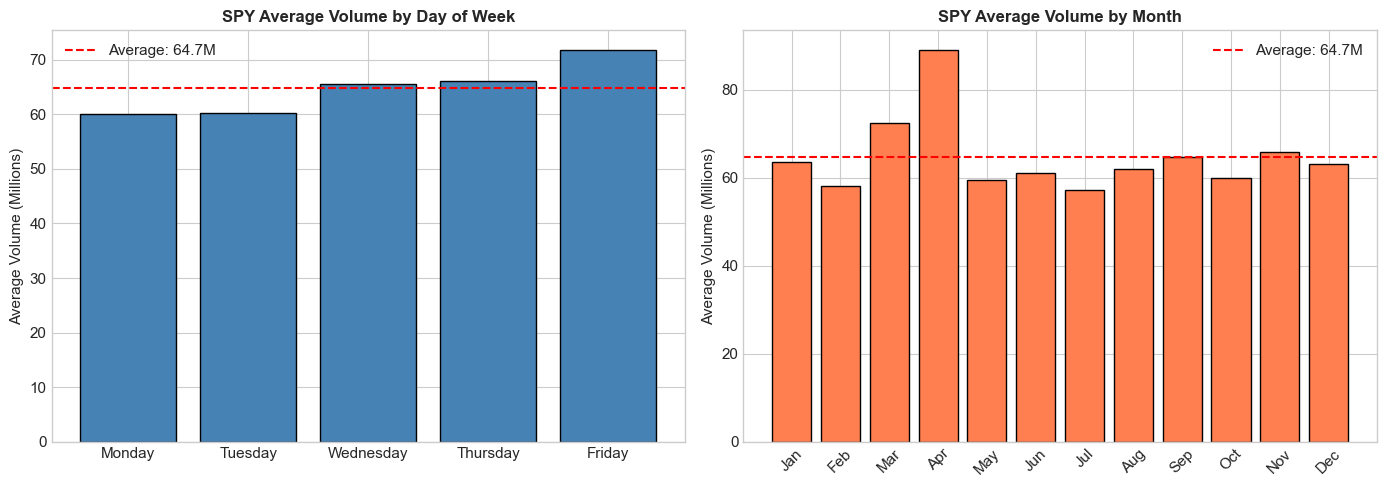


Seasonal Liquidity Patterns:
  Highest volume day: Friday (71.7M avg)
  Lowest volume day: Monday (60.0M avg)
  Highest volume month: Apr (89.1M avg)
  Lowest volume month: Jul (57.2M avg)


In [18]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Day of week volume pattern
ax1 = axes[0]
dow_vol = liquidity_df.groupby('DayOfWeek')['SPY_Volume'].mean() / 1e6
bars = ax1.bar([day_names[i] for i in dow_vol.index], dow_vol.values, color='steelblue', edgecolor='black')
ax1.axhline(y=dow_vol.mean(), color='red', linestyle='--', label=f'Average: {dow_vol.mean():.1f}M')
ax1.set_ylabel('Average Volume (Millions)')
ax1.set_title('SPY Average Volume by Day of Week', fontsize=12, fontweight='bold')
ax1.legend()

# Monthly volume pattern
ax2 = axes[1]
month_vol = liquidity_df.groupby('Month')['SPY_Volume'].mean() / 1e6
bars = ax2.bar([month_names[i] for i in month_vol.index], month_vol.values, color='coral', edgecolor='black')
ax2.axhline(y=month_vol.mean(), color='red', linestyle='--', label=f'Average: {month_vol.mean():.1f}M')
ax2.set_ylabel('Average Volume (Millions)')
ax2.set_title('SPY Average Volume by Month', fontsize=12, fontweight='bold')
ax2.legend()
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Print findings
print("\nSeasonal Liquidity Patterns:")
print(f"  Highest volume day: {day_names[dow_vol.idxmax()]} ({dow_vol.max():.1f}M avg)")
print(f"  Lowest volume day: {day_names[dow_vol.idxmin()]} ({dow_vol.min():.1f}M avg)")
print(f"  Highest volume month: {month_names[month_vol.idxmax()]} ({month_vol.max():.1f}M avg)")
print(f"  Lowest volume month: {month_names[month_vol.idxmin()]} ({month_vol.min():.1f}M avg)")

## 9. Confidence Intervals for Liquidity Metrics

Statistical confidence intervals (95% CI) for all key liquidity metrics using:
- **Parametric**: t-distribution based intervals
- **Bootstrap**: Non-parametric resampling (10,000 iterations)

In [19]:
from scipy import stats

def calculate_ci_parametric(data, confidence=0.95):
    """Calculate confidence interval using t-distribution"""
    data = data.dropna()
    n = len(data)
    mean = data.mean()
    se = stats.sem(data)
    h = se * stats.t.ppf((1 + confidence) / 2, n - 1)
    return mean, mean - h, mean + h, se

def calculate_ci_bootstrap(data, confidence=0.95, n_bootstrap=10000):
    """Calculate confidence interval using bootstrap resampling"""
    data = data.dropna().values
    n = len(data)
    bootstrap_means = np.array([np.mean(np.random.choice(data, size=n, replace=True)) 
                                 for _ in range(n_bootstrap)])
    lower = np.percentile(bootstrap_means, (1 - confidence) / 2 * 100)
    upper = np.percentile(bootstrap_means, (1 + confidence) / 2 * 100)
    return np.mean(data), lower, upper, np.std(bootstrap_means)

print("Confidence interval functions defined")

Confidence interval functions defined


In [20]:
# Calculate confidence intervals for all key metrics
np.random.seed(42)  # For reproducibility

metrics = {
    'SPY Volume (M)': liquidity_df['SPY_Volume'] / 1e6,
    'Dollar Volume ($B)': liquidity_df['SPY_Dollar_Volume'] / 1e9,
    'Volume Ratio': liquidity_df['Volume_Ratio'],
    'VIX': liquidity_df['VIX'],
    'Realized Volatility (%)': liquidity_df['Realized_Vol'],
    'VIX-RV Spread': liquidity_df['VIX_RV_Spread'],
    'SPY Range (%)': liquidity_df['SPY_Range'],
    'Liquidity Index': liquidity_df['Liquidity_Index'],
    'SPY Daily Return (%)': liquidity_df['SPY_Return'],
}

print("=" * 90)
print("                    95% CONFIDENCE INTERVALS FOR LIQUIDITY METRICS")
print("=" * 90)
print(f"{'Metric':<25} {'Mean':>12} {'95% CI (Parametric)':>25} {'95% CI (Bootstrap)':>25}")
print("-" * 90)

ci_results = {}
for name, data in metrics.items():
    mean_p, lower_p, upper_p, se_p = calculate_ci_parametric(data)
    mean_b, lower_b, upper_b, se_b = calculate_ci_bootstrap(data)
    ci_results[name] = {
        'mean': mean_p,
        'parametric_ci': (lower_p, upper_p),
        'bootstrap_ci': (lower_b, upper_b),
        'se_parametric': se_p,
        'se_bootstrap': se_b
    }
    print(f"{name:<25} {mean_p:>12.3f} [{lower_p:>10.3f}, {upper_p:>10.3f}] [{lower_b:>10.3f}, {upper_b:>10.3f}]")

print("=" * 90)

                    95% CONFIDENCE INTERVALS FOR LIQUIDITY METRICS
Metric                            Mean       95% CI (Parametric)        95% CI (Bootstrap)
------------------------------------------------------------------------------------------
SPY Volume (M)                  64.722 [    62.411,     67.034] [    62.467,     67.154]
Dollar Volume ($B)              37.626 [    36.234,     39.018] [    36.254,     39.038]
Volume Ratio                     1.008 [     0.978,      1.038] [     0.978,      1.039]


VIX                             17.350 [    16.935,     17.765] [    16.946,     17.769]
Realized Volatility (%)         14.185 [    13.390,     14.980] [    13.426,     15.012]
VIX-RV Spread                    3.311 [     2.702,      3.920] [     2.690,      3.892]
SPY Range (%)                    1.046 [     0.973,      1.120] [     0.978,      1.123]


Liquidity Index                 56.033 [    54.119,     57.948] [    54.098,     57.945]
SPY Daily Return (%)             0.078 [    -0.013,      0.168] [    -0.011,      0.170]


In [21]:
# Confidence intervals for returns by liquidity regime
print("\n" + "=" * 95)
print("            95% CONFIDENCE INTERVALS FOR FORWARD RETURNS BY LIQUIDITY REGIME")
print("=" * 95)

return_cols = ['Fwd_Return_1d', 'Fwd_Return_5d', 'Fwd_Return_20d']
return_names = ['1-Day Forward', '5-Day Forward', '20-Day Forward']

regime_ci_results = {}

for ret_col, ret_name in zip(return_cols, return_names):
    print(f"\n{ret_name} Returns (%)")
    print("-" * 95)
    print(f"{'Regime':<10} {'N':>6} {'Mean':>10} {'Std':>10} {'95% CI (Parametric)':>25} {'95% CI (Bootstrap)':>25}")
    print("-" * 95)
    
    regime_ci_results[ret_name] = {}
    
    for regime in ['High', 'Normal', 'Low']:
        regime_data = liquidity_df[liquidity_df['Regime'] == regime][ret_col].dropna()
        if len(regime_data) > 1:
            mean_p, lower_p, upper_p, se_p = calculate_ci_parametric(regime_data)
            mean_b, lower_b, upper_b, se_b = calculate_ci_bootstrap(regime_data)
            std = regime_data.std()
            n = len(regime_data)
            
            regime_ci_results[ret_name][regime] = {
                'n': n,
                'mean': mean_p,
                'std': std,
                'parametric_ci': (lower_p, upper_p),
                'bootstrap_ci': (lower_b, upper_b)
            }
            
            print(f"{regime:<10} {n:>6} {mean_p:>10.4f} {std:>10.4f} [{lower_p:>10.4f}, {upper_p:>10.4f}] [{lower_b:>10.4f}, {upper_b:>10.4f}]")

print("\n" + "=" * 95)


            95% CONFIDENCE INTERVALS FOR FORWARD RETURNS BY LIQUIDITY REGIME

1-Day Forward Returns (%)
-----------------------------------------------------------------------------------------------
Regime          N       Mean        Std       95% CI (Parametric)        95% CI (Bootstrap)
-----------------------------------------------------------------------------------------------
High          115     0.0367     0.6492 [   -0.0832,     0.1566] [   -0.0806,     0.1529]
Normal         66     0.2814     1.6262 [   -0.1183,     0.6812] [   -0.0593,     0.7158]


Low           318     0.0496     0.9879 [   -0.0594,     0.1586] [   -0.0598,     0.1560]

5-Day Forward Returns (%)
-----------------------------------------------------------------------------------------------
Regime          N       Mean        Std       95% CI (Parametric)        95% CI (Bootstrap)
-----------------------------------------------------------------------------------------------


High          111     0.3231     1.2154 [    0.0945,     0.5517] [    0.0953,     0.5499]
Normal         66     0.4541     2.4220 [   -0.1413,     1.0494] [   -0.1269,     1.0156]
Low           318     0.4103     2.2191 [    0.1655,     0.6552] [    0.1650,     0.6505]

20-Day Forward Returns (%)
-----------------------------------------------------------------------------------------------
Regime          N       Mean        Std       95% CI (Parametric)        95% CI (Bootstrap)
-----------------------------------------------------------------------------------------------


High           96     2.1785     1.4174 [    1.8913,     2.4657] [    1.8871,     2.4592]


Normal         66     1.6537     3.4192 [    0.8132,     2.4943] [    0.8231,     2.4570]
Low           318     1.3586     4.0143 [    0.9157,     1.8015] [    0.9158,     1.8017]



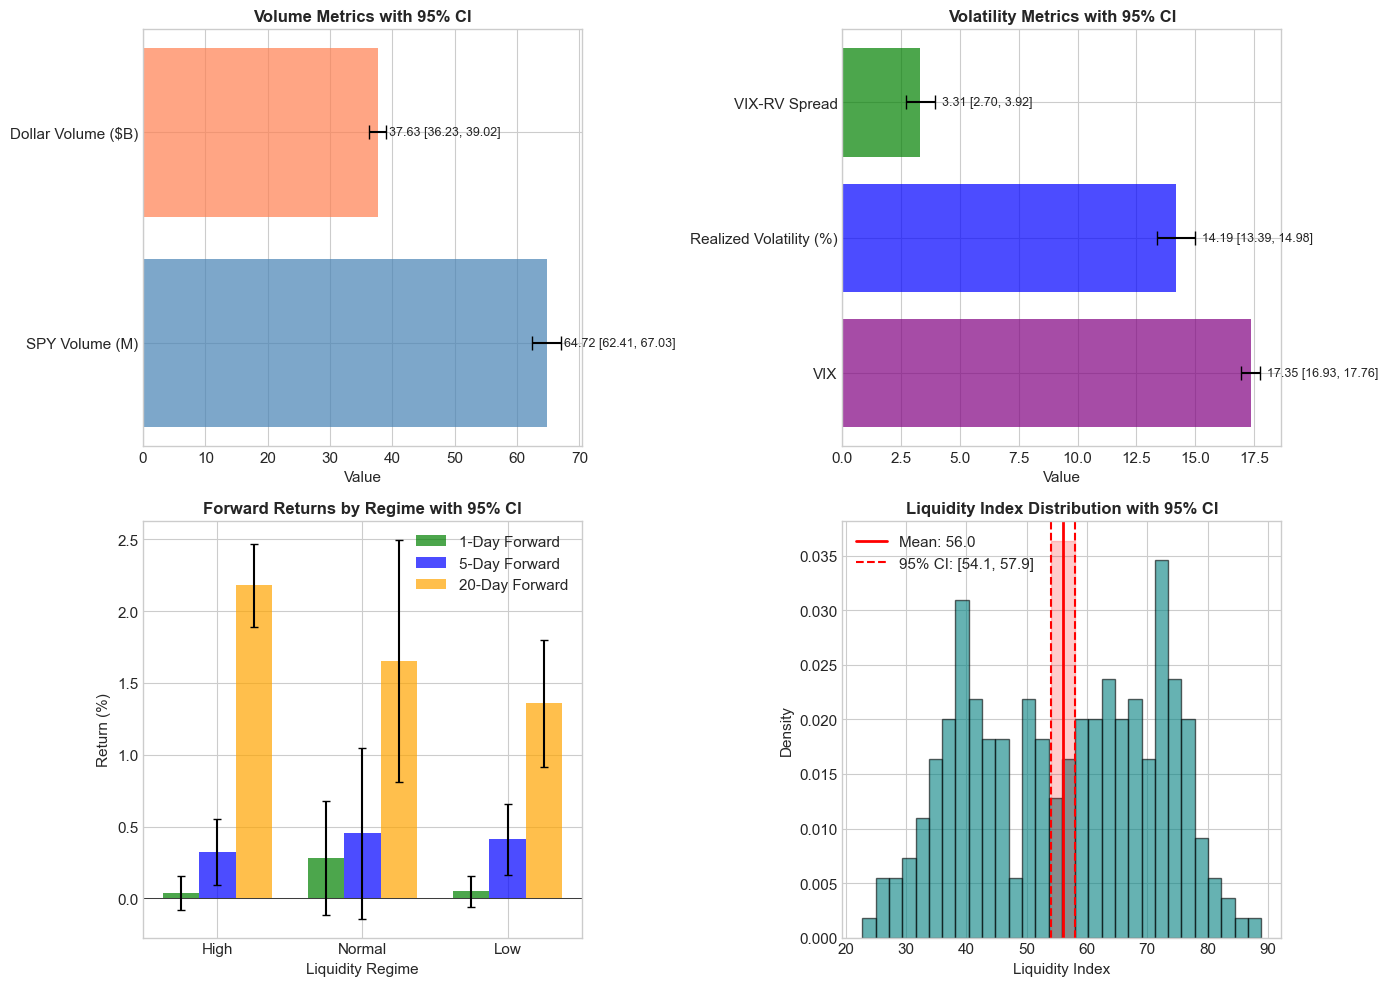

In [22]:
# Visualize confidence intervals
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Volume metrics CI
ax1 = axes[0, 0]
vol_metrics = ['SPY Volume (M)', 'Dollar Volume ($B)']
y_pos = np.arange(len(vol_metrics))
means = [ci_results[m]['mean'] for m in vol_metrics]
ci_lows = [ci_results[m]['mean'] - ci_results[m]['parametric_ci'][0] for m in vol_metrics]
ci_highs = [ci_results[m]['parametric_ci'][1] - ci_results[m]['mean'] for m in vol_metrics]

ax1.barh(y_pos, means, xerr=[ci_lows, ci_highs], capsize=5, color=['steelblue', 'coral'], alpha=0.7)
ax1.set_yticks(y_pos)
ax1.set_yticklabels(vol_metrics)
ax1.set_xlabel('Value')
ax1.set_title('Volume Metrics with 95% CI', fontsize=12, fontweight='bold')
for i, (m, ci_l, ci_h) in enumerate(zip(means, ci_lows, ci_highs)):
    ax1.text(m + ci_h + 0.5, i, f'{m:.2f} [{m-ci_l:.2f}, {m+ci_h:.2f}]', va='center', fontsize=9)

# Plot 2: VIX metrics CI
ax2 = axes[0, 1]
vix_metrics = ['VIX', 'Realized Volatility (%)', 'VIX-RV Spread']
y_pos = np.arange(len(vix_metrics))
means = [ci_results[m]['mean'] for m in vix_metrics]
ci_lows = [ci_results[m]['mean'] - ci_results[m]['parametric_ci'][0] for m in vix_metrics]
ci_highs = [ci_results[m]['parametric_ci'][1] - ci_results[m]['mean'] for m in vix_metrics]

ax2.barh(y_pos, means, xerr=[ci_lows, ci_highs], capsize=5, color=['purple', 'blue', 'green'], alpha=0.7)
ax2.set_yticks(y_pos)
ax2.set_yticklabels(vix_metrics)
ax2.set_xlabel('Value')
ax2.set_title('Volatility Metrics with 95% CI', fontsize=12, fontweight='bold')
for i, (m, ci_l, ci_h) in enumerate(zip(means, ci_lows, ci_highs)):
    ax2.text(m + ci_h + 0.3, i, f'{m:.2f} [{m-ci_l:.2f}, {m+ci_h:.2f}]', va='center', fontsize=9)

# Plot 3: Forward returns by regime with CI
ax3 = axes[1, 0]
regimes = ['High', 'Normal', 'Low']
x = np.arange(len(regimes))
width = 0.25

for i, (ret_name, color) in enumerate(zip(['1-Day Forward', '5-Day Forward', '20-Day Forward'], 
                                          ['green', 'blue', 'orange'])):
    means = [regime_ci_results[ret_name][r]['mean'] for r in regimes]
    ci_lows = [regime_ci_results[ret_name][r]['mean'] - regime_ci_results[ret_name][r]['parametric_ci'][0] for r in regimes]
    ci_highs = [regime_ci_results[ret_name][r]['parametric_ci'][1] - regime_ci_results[ret_name][r]['mean'] for r in regimes]
    ax3.bar(x + i*width, means, width, yerr=[ci_lows, ci_highs], capsize=3, 
            label=ret_name, color=color, alpha=0.7)

ax3.set_xticks(x + width)
ax3.set_xticklabels(regimes)
ax3.set_ylabel('Return (%)')
ax3.set_xlabel('Liquidity Regime')
ax3.set_title('Forward Returns by Regime with 95% CI', fontsize=12, fontweight='bold')
ax3.legend()
ax3.axhline(y=0, color='black', linestyle='-', linewidth=0.5)

# Plot 4: Liquidity Index distribution with CI
ax4 = axes[1, 1]
liq_data = liquidity_df['Liquidity_Index'].dropna()
ax4.hist(liq_data, bins=30, density=True, alpha=0.6, color='teal', edgecolor='black')

# Add CI lines
mean_val = ci_results['Liquidity Index']['mean']
ci_low, ci_high = ci_results['Liquidity Index']['parametric_ci']
ax4.axvline(mean_val, color='red', linestyle='-', linewidth=2, label=f'Mean: {mean_val:.1f}')
ax4.axvline(ci_low, color='red', linestyle='--', linewidth=1.5, label=f'95% CI: [{ci_low:.1f}, {ci_high:.1f}]')
ax4.axvline(ci_high, color='red', linestyle='--', linewidth=1.5)
ax4.fill_betweenx([0, ax4.get_ylim()[1]], ci_low, ci_high, alpha=0.2, color='red')

ax4.set_xlabel('Liquidity Index')
ax4.set_ylabel('Density')
ax4.set_title('Liquidity Index Distribution with 95% CI', fontsize=12, fontweight='bold')
ax4.legend()

plt.tight_layout()
plt.show()

In [23]:
# Rolling confidence intervals for key metrics
window = 60  # 60-day rolling window

def rolling_ci(series, window, confidence=0.95):
    """Calculate rolling confidence intervals"""
    rolling_mean = series.rolling(window).mean()
    rolling_std = series.rolling(window).std()
    rolling_count = series.rolling(window).count()
    
    t_value = stats.t.ppf((1 + confidence) / 2, window - 1)
    margin = t_value * rolling_std / np.sqrt(rolling_count)
    
    return rolling_mean, rolling_mean - margin, rolling_mean + margin

# Calculate rolling CIs
vol_mean, vol_ci_low, vol_ci_high = rolling_ci(liquidity_df['SPY_Volume'] / 1e6, window)
vix_mean, vix_ci_low, vix_ci_high = rolling_ci(liquidity_df['VIX'], window)
liq_mean, liq_ci_low, liq_ci_high = rolling_ci(liquidity_df['Liquidity_Index'], window)

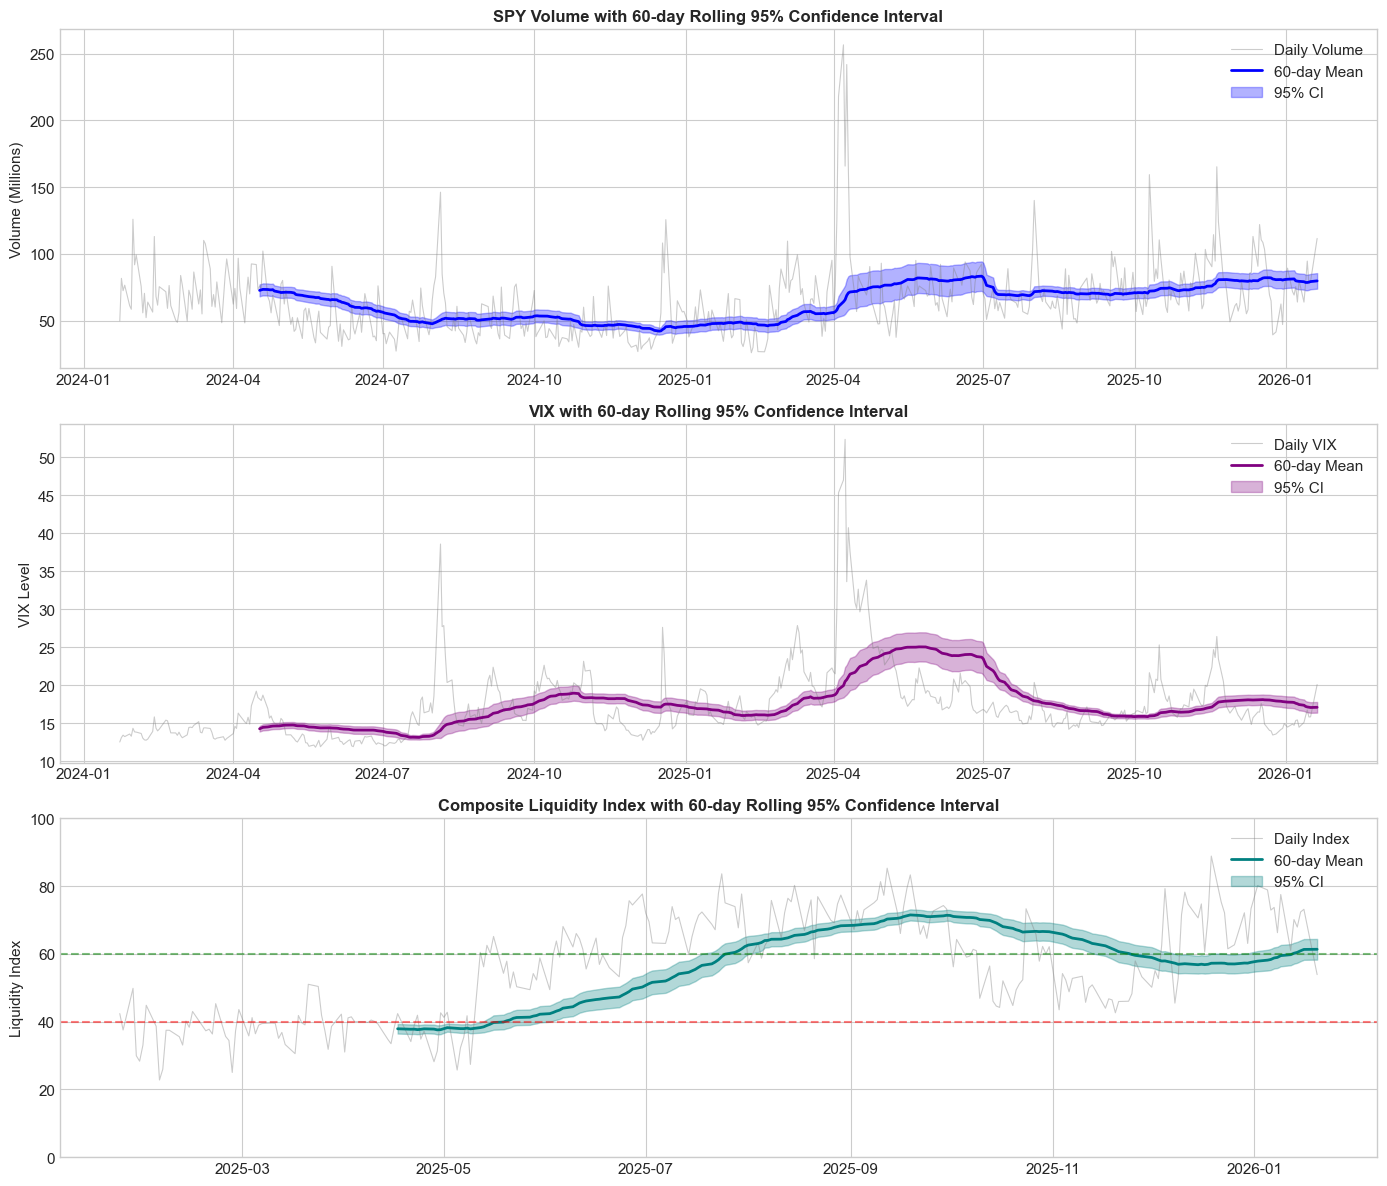

In [24]:
# Plot rolling confidence intervals
fig, axes = plt.subplots(3, 1, figsize=(14, 12))

# Plot 1: SPY Volume with rolling CI
ax1 = axes[0]
ax1.plot(liquidity_df.index, liquidity_df['SPY_Volume']/1e6, color='gray', alpha=0.4, linewidth=0.8, label='Daily Volume')
ax1.plot(liquidity_df.index, vol_mean, color='blue', linewidth=2, label='60-day Mean')
ax1.fill_between(liquidity_df.index, vol_ci_low, vol_ci_high, alpha=0.3, color='blue', label='95% CI')
ax1.set_ylabel('Volume (Millions)')
ax1.set_title('SPY Volume with 60-day Rolling 95% Confidence Interval', fontsize=12, fontweight='bold')
ax1.legend(loc='upper right')

# Plot 2: VIX with rolling CI
ax2 = axes[1]
ax2.plot(liquidity_df.index, liquidity_df['VIX'], color='gray', alpha=0.4, linewidth=0.8, label='Daily VIX')
ax2.plot(liquidity_df.index, vix_mean, color='purple', linewidth=2, label='60-day Mean')
ax2.fill_between(liquidity_df.index, vix_ci_low, vix_ci_high, alpha=0.3, color='purple', label='95% CI')
ax2.set_ylabel('VIX Level')
ax2.set_title('VIX with 60-day Rolling 95% Confidence Interval', fontsize=12, fontweight='bold')
ax2.legend(loc='upper right')

# Plot 3: Liquidity Index with rolling CI
ax3 = axes[2]
ax3.plot(liquidity_df.index, liquidity_df['Liquidity_Index'], color='gray', alpha=0.4, linewidth=0.8, label='Daily Index')
ax3.plot(liquidity_df.index, liq_mean, color='teal', linewidth=2, label='60-day Mean')
ax3.fill_between(liquidity_df.index, liq_ci_low, liq_ci_high, alpha=0.3, color='teal', label='95% CI')
ax3.axhline(y=60, color='green', linestyle='--', alpha=0.5)
ax3.axhline(y=40, color='red', linestyle='--', alpha=0.5)
ax3.set_ylabel('Liquidity Index')
ax3.set_title('Composite Liquidity Index with 60-day Rolling 95% Confidence Interval', fontsize=12, fontweight='bold')
ax3.legend(loc='upper right')
ax3.set_ylim(0, 100)

plt.tight_layout()
plt.show()

In [25]:
# Comprehensive CI Summary Table
print("\n" + "=" * 100)
print("                      COMPREHENSIVE CONFIDENCE INTERVAL SUMMARY")
print("=" * 100)
print(f"\nData Period: {liquidity_df.index[0].strftime('%Y-%m-%d')} to {liquidity_df.index[-1].strftime('%Y-%m-%d')}")
print(f"Total Observations: {len(liquidity_df)}")
print(f"Confidence Level: 95%")

print("\n" + "-" * 100)
print(f"{'METRIC':<30} {'MEAN':>12} {'STD':>12} {'SE':>12} {'95% CI LOWER':>15} {'95% CI UPPER':>15}")
print("-" * 100)

detailed_metrics = [
    ('SPY Volume (M shares)', liquidity_df['SPY_Volume'] / 1e6),
    ('SPY Dollar Volume ($B)', liquidity_df['SPY_Dollar_Volume'] / 1e9),
    ('Volume Ratio', liquidity_df['Volume_Ratio']),
    ('Volume Z-Score', liquidity_df['Volume_ZScore']),
    ('VIX', liquidity_df['VIX']),
    ('VIX 20-day MA', liquidity_df['VIX_MA20']),
    ('Realized Volatility (%)', liquidity_df['Realized_Vol']),
    ('VIX-RV Spread', liquidity_df['VIX_RV_Spread']),
    ('SPY Intraday Range (%)', liquidity_df['SPY_Range']),
    ('Liquidity Index', liquidity_df['Liquidity_Index']),
    ('Volume Score', liquidity_df['Volume_Score']),
    ('VIX Score (inverted)', liquidity_df['VIX_Score']),
    ('Range Score (inverted)', liquidity_df['Range_Score']),
    ('SPY Daily Return (%)', liquidity_df['SPY_Return']),
    ('1-Day Forward Return (%)', liquidity_df['Fwd_Return_1d']),
    ('5-Day Forward Return (%)', liquidity_df['Fwd_Return_5d']),
    ('20-Day Forward Return (%)', liquidity_df['Fwd_Return_20d']),
]

for name, data in detailed_metrics:
    data_clean = data.dropna()
    n = len(data_clean)
    mean = data_clean.mean()
    std = data_clean.std()
    se = stats.sem(data_clean)
    ci_low, ci_high = stats.t.interval(0.95, n-1, loc=mean, scale=se)
    print(f"{name:<30} {mean:>12.4f} {std:>12.4f} {se:>12.4f} {ci_low:>15.4f} {ci_high:>15.4f}")

print("=" * 100)
print("\nNote: SE = Standard Error of the Mean")
print("      CI = Confidence Interval using t-distribution")


                      COMPREHENSIVE CONFIDENCE INTERVAL SUMMARY

Data Period: 2024-01-23 to 2026-01-20
Total Observations: 500
Confidence Level: 95%

----------------------------------------------------------------------------------------------------
METRIC                                 MEAN          STD           SE    95% CI LOWER    95% CI UPPER
----------------------------------------------------------------------------------------------------
SPY Volume (M shares)               64.7221      26.3070       1.1765         62.4106         67.0336
SPY Dollar Volume ($B)              37.6261      15.8441       0.7086         36.2339         39.0182
Volume Ratio                         1.0082       0.3379       0.0154          0.9779          1.0385
Volume Z-Score                      -0.0042       1.0781       0.0508         -0.1039          0.0956
VIX                                 17.3497       4.7237       0.2112         16.9347         17.7648
VIX 20-day MA                      

In [26]:
# Current values vs historical confidence intervals
print("\n" + "=" * 85)
print("           CURRENT VALUES VS HISTORICAL 95% CONFIDENCE INTERVALS")
print("=" * 85)
print(f"\nCurrent Date: {liquidity_df.index[-1].strftime('%Y-%m-%d')}")
print("\n" + "-" * 85)
print(f"{'METRIC':<30} {'CURRENT':>12} {'HIST MEAN':>12} {'95% CI':>25} {'STATUS':>10}")
print("-" * 85)

current_metrics = [
    ('SPY Volume (M)', liquidity_df['SPY_Volume'].iloc[-1] / 1e6, liquidity_df['SPY_Volume'] / 1e6),
    ('Dollar Volume ($B)', liquidity_df['SPY_Dollar_Volume'].iloc[-1] / 1e9, liquidity_df['SPY_Dollar_Volume'] / 1e9),
    ('Volume Ratio', liquidity_df['Volume_Ratio'].iloc[-1], liquidity_df['Volume_Ratio']),
    ('VIX', liquidity_df['VIX'].iloc[-1], liquidity_df['VIX']),
    ('Realized Vol (%)', liquidity_df['Realized_Vol'].iloc[-1], liquidity_df['Realized_Vol']),
    ('VIX-RV Spread', liquidity_df['VIX_RV_Spread'].iloc[-1], liquidity_df['VIX_RV_Spread']),
    ('SPY Range (%)', liquidity_df['SPY_Range'].iloc[-1], liquidity_df['SPY_Range']),
    ('Liquidity Index', liquidity_df['Liquidity_Index'].iloc[-1], liquidity_df['Liquidity_Index']),
]

for name, current, hist_data in current_metrics:
    hist_clean = hist_data.dropna()
    n = len(hist_clean)
    mean = hist_clean.mean()
    se = stats.sem(hist_clean)
    ci_low, ci_high = stats.t.interval(0.95, n-1, loc=mean, scale=se)
    
    if current < ci_low:
        status = "BELOW CI"
    elif current > ci_high:
        status = "ABOVE CI"
    else:
        status = "NORMAL"
    
    print(f"{name:<30} {current:>12.3f} {mean:>12.3f} [{ci_low:>10.3f}, {ci_high:>10.3f}] {status:>10}")

print("=" * 85)
print("\nStatus Legend:")
print("  NORMAL   = Current value within historical 95% CI")
print("  ABOVE CI = Current value above historical 95% CI (unusually high)")
print("  BELOW CI = Current value below historical 95% CI (unusually low)")


           CURRENT VALUES VS HISTORICAL 95% CONFIDENCE INTERVALS

Current Date: 2026-01-20

-------------------------------------------------------------------------------------
METRIC                              CURRENT    HIST MEAN                    95% CI     STATUS
-------------------------------------------------------------------------------------
SPY Volume (M)                      111.623       64.722 [    62.411,     67.034]   ABOVE CI
Dollar Volume ($B)                   75.634       37.626 [    36.234,     39.018]   ABOVE CI
Volume Ratio                          1.530        1.008 [     0.978,      1.038]   ABOVE CI
VIX                                  20.090       17.350 [    16.935,     17.765]   ABOVE CI
Realized Vol (%)                     10.380       14.185 [    13.390,     14.980]   BELOW CI
VIX-RV Spread                         9.710        3.311 [     2.702,      3.920]   ABOVE CI
SPY Range (%)                         1.210        1.046 [     0.973,      1.120]  

## 8. Current Liquidity Dashboard

In [27]:
# Final dashboard
latest = liquidity_df.iloc[-1]
prev_week = liquidity_df.iloc[-5]
prev_month = liquidity_df.iloc[-20] if len(liquidity_df) >= 20 else liquidity_df.iloc[0]

print("="*70)
print("              US MARKET LIQUIDITY DASHBOARD")
print("="*70)
print(f"                   Date: {liquidity_df.index[-1].strftime('%Y-%m-%d')}")
print("="*70)

print("\n[VOLUME METRICS]")
print(f"  SPY Volume:           {latest['SPY_Volume']/1e6:.1f}M shares")
print(f"  Volume vs 20-day avg: {latest['Volume_Ratio']:.2f}x")
print(f"  Dollar Volume:        ${latest['SPY_Dollar_Volume']/1e9:.2f}B")

print("\n[VOLATILITY METRICS]")
print(f"  VIX Level:            {latest['VIX']:.2f}")
print(f"  VIX 1yr Percentile:   {latest['VIX_Percentile']*100:.1f}%")
print(f"  Realized Vol (20d):   {latest['Realized_Vol']:.1f}%")
print(f"  VIX-RV Spread:        {latest['VIX_RV_Spread']:.1f}")

print("\n[COMPOSITE LIQUIDITY INDEX]")
print(f"  Current Score:        {latest['Liquidity_Index_MA5']:.1f}/100")
print(f"  1-Week Ago:           {prev_week['Liquidity_Index_MA5']:.1f}/100")
print(f"  1-Month Ago:          {prev_month['Liquidity_Index_MA5']:.1f}/100")

# Determine overall assessment
idx = latest['Liquidity_Index_MA5']
if idx >= 65:
    assessment = "HIGH LIQUIDITY - Favorable for large trades"
    color_code = "GREEN"
elif idx >= 50:
    assessment = "NORMAL LIQUIDITY - Standard market conditions"
    color_code = "YELLOW"
elif idx >= 35:
    assessment = "BELOW AVERAGE - Use caution with size"
    color_code = "ORANGE"
else:
    assessment = "LOW LIQUIDITY - Market stress conditions"
    color_code = "RED"

print("\n" + "="*70)
print(f"OVERALL ASSESSMENT: [{color_code}]")
print(f"  {assessment}")
print("="*70)

              US MARKET LIQUIDITY DASHBOARD
                   Date: 2026-01-20

[VOLUME METRICS]
  SPY Volume:           111.6M shares
  Volume vs 20-day avg: 1.53x
  Dollar Volume:        $75.63B

[VOLATILITY METRICS]
  VIX Level:            20.09
  VIX 1yr Percentile:   75.4%
  Realized Vol (20d):   10.4%
  VIX-RV Spread:        9.7

[COMPOSITE LIQUIDITY INDEX]
  Current Score:        67.5/100
  1-Week Ago:           69.7/100
  1-Month Ago:          73.1/100

OVERALL ASSESSMENT: [GREEN]
  HIGH LIQUIDITY - Favorable for large trades


In [28]:
# Save processed data for further analysis
output_cols = ['SPY_Close', 'SPY_Volume', 'SPY_Dollar_Volume', 'VIX', 'Volume_Ratio', 
               'VIX_Percentile', 'Realized_Vol', 'Liquidity_Index', 'Liquidity_Index_MA5', 'Regime']
liquidity_df[output_cols].to_csv('liquidity_analysis_data.csv')
print("Data saved to 'liquidity_analysis_data.csv'")

Data saved to 'liquidity_analysis_data.csv'
